In [1]:
import numpy as np
import pygmsh

In [2]:
import firedrake
import matplotlib.pyplot as plt

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


# Ice sheet surface topography
We start this demo by using the equations discussed previously to solve for an equailbrium surface elevation profile for a synthetic ice shelf. This elevation model is consistent with the climate geometry and glaciological parameters that define the ice shelf and will be used to determine the hydropotential of the surface.

We first build a mesh meant to represent an idealized ice shelf similar to ice shelves of the Antarctic peninsula fed by multiple ice streams that form a gibus-like geometry.

In [3]:
import pygmsh

R = 200e3
δx = 5e3

geometry = pygmsh.built_in.Geometry()

x1 = geometry.add_point([-R, 0, 0], lcar=δx)
x2 = geometry.add_point([+R, 0, 0], lcar=δx)

center1 = geometry.add_point([0, 0, 0,], lcar=δx)
center2 = geometry.add_point([0, -4 * R, 0], lcar=δx)

arcs = [
    geometry.add_circle_arc(x1, center1, x2),
    geometry.add_circle_arc(x2, center2, x1)
]



In [4]:
line_loop = geometry.add_line_loop(arcs)
plane_surface = geometry.add_plane_surface(line_loop)

physical_lines = [geometry.add_physical(arc) for arc in arcs]
physical_surface = geometry.add_physical(plane_surface)

In [5]:
with open("ice-shelf.geo", "w") as geo_file:
    geo_file.write(geometry.get_code())

In [6]:
!gmsh -2 -format msh2 -o ice-shelf.msh ice-shelf.geo

Info    : Running '/home/hoffmaao/firedrake/bin/gmsh -2 -format msh2 -o ice-shelf.msh ice-shelf.geo' [Gmsh 4.11.1, 1 node, max. 1 thread]
Info    : Started on Mon Feb 12 11:28:51 2024
Info    : Reading 'ice-shelf.geo'...
Info    : Done reading 'ice-shelf.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 50%] Meshing curve 2 (Circle)
Info    : Done meshing 1D (Wall 0.000418578s, CPU 0.000608s)
Info    : Meshing 2D...
Info    : Meshing surface 4 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0782373s, CPU 0.075056s)
Info    : 3373 nodes 6744 elements
Info    : Writing 'ice-shelf.msh'...
Info    : Done writing 'ice-shelf.msh'
Info    : Stopped on Mon Feb 12 11:28:51 2024 (From start: Wall 0.0932756s, CPU 2.61751s)


In [7]:
import firedrake

mesh = firedrake.Mesh("ice-shelf.msh")

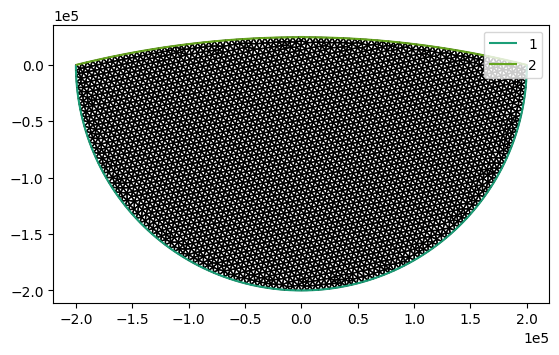

In [8]:
import icepack.plot
import matplotlib.pyplot as plt

fig, axes = icepack.plot.subplots()
firedrake.triplot(mesh, axes=axes)
axes.legend();



In [9]:
import numpy as np
from numpy import pi as π

inlet_angles = π * np.array([-3/4, -1/2, -1/3, -1/6])
inlet_widths = π * np.array([1/8, 1/12, 1/24, 1/12])

In [10]:
from firedrake import inner, as_vector

x = firedrake.SpatialCoordinate(mesh)

u_in = 300
h_in = 350
hb = 100
dh, du = 400, 250

hs, us = [], []
for θ, ϕ in zip(inlet_angles, inlet_widths):
    x0 = R * as_vector((np.cos(θ), np.sin(θ)))
    v = -as_vector((np.cos(θ), np.sin(θ)))
    L = inner(x - x0, v)
    W = x - x0 - L * v
    Rn = 2 * ϕ / π * R
    q = firedrake.max_value(1 - (W / Rn)**2, 0)
    hs.append(hb + q * ((h_in - hb) - dh * L /R))
    us.append(firedrake.exp(-4 * (W/R)**2) * (u_in + du * L / R) * v)

In [11]:
h_expr = firedrake.Constant(hb)
for h in hs:
    h_expr = firedrake.max_value(h, h_expr)
    
u_expr = sum(us)

In [12]:


Q = firedrake.FunctionSpace(mesh, "CG", 2)
V = firedrake.VectorFunctionSpace(mesh, "CG", 2)

h0 = firedrake.interpolate(h_expr, Q)
u0 = firedrake.interpolate(u_expr, V)



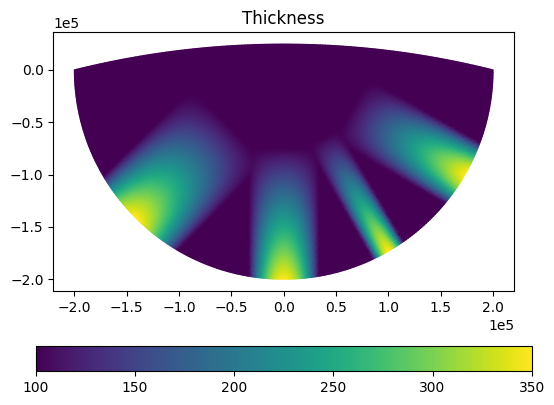

In [13]:
fig, axes = icepack.plot.subplots()
axes.set_title("Thickness")
colors = firedrake.tripcolor(h0, axes=axes)
fig.colorbar(colors, orientation="horizontal");

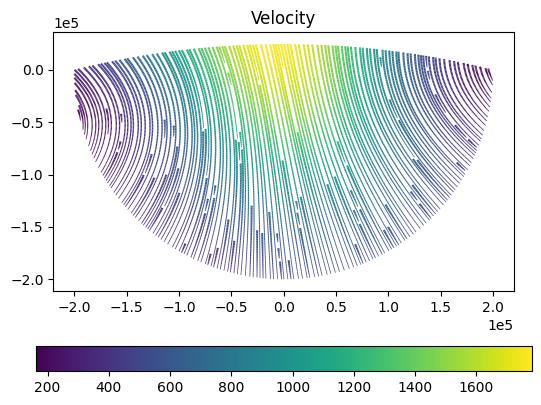

In [14]:
fig, axes = icepack.plot.subplots()
axes.set_title("Velocity")
streamlines = firedrake.streamplot(u0, resolution=2e3, axes=axes)
fig.colorbar(streamlines, orientation="horizontal");


In [15]:
import icepack

model = icepack.models.IceShelf()

In [16]:
solver = icepack.solvers.FlowSolver(model, dirichlet_ids=[1])

In [17]:
T = firedrake.Constant(255.15)
A = icepack.rate_factor(T)

In [18]:
h = h0.copy(deepcopy=True)
u = solver.diagnostic_solve(
    velocity=u0,
    thickness=h,
    fluidity=A,
)

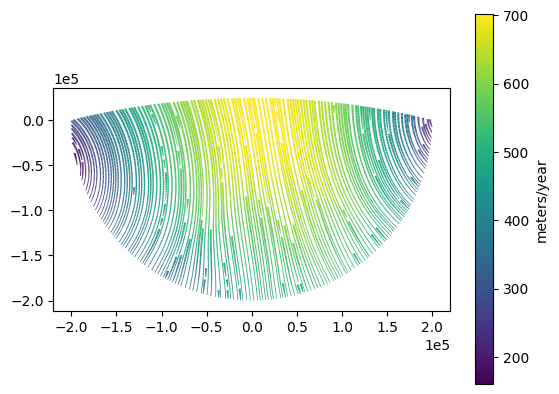

In [19]:
fig, axes = icepack.plot.subplots()
streamlines = firedrake.streamplot(u, resolution=2e3, axes=axes)
fig.colorbar(streamlines, label="meters/year");

In [20]:
import tqdm

final_time = 400.
num_timesteps = 200
dt = final_time / num_timesteps
a = firedrake.Constant(0.0)

for step in tqdm.trange(num_timesteps):
    h = solver.prognostic_solve(
        dt,
        thickness=h, 
        velocity=u,
        accumulation=a,
        thickness_inflow=h0,
    )
    
    u = solver.diagnostic_solve(
        velocity=u,
        thickness=h,
        fluidity=A,
    )

100%|█████████████████████████████████████████| 200/200 [01:45<00:00,  1.90it/s]


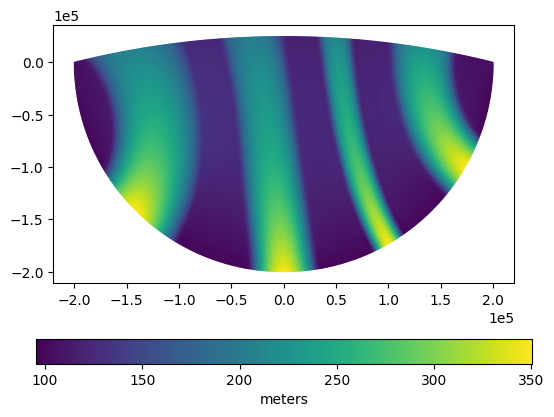

In [21]:
fig, axes = icepack.plot.subplots()
colors = firedrake.tripcolor(h, axes=axes)
fig.colorbar(colors, label="meters", orientation="horizontal");

In [22]:
cg1 = firedrake.FiniteElement("CG", "triangle", 1)
Q2 = firedrake.FunctionSpace(mesh, cg1)
b3 = firedrake.FiniteElement("B", "triangle", 3)
#DG = firedrake.FunctionSpace(mesh,"DG", 2)
#RT = firedrake.FunctionSpace(mesh, "RT", 2)
V2 = firedrake.VectorFunctionSpace(mesh, cg1 + b3)
Z = Q2 * V2
#Z = DG * RT

In [23]:
h_water_0 = firedrake.interpolate(firedrake.Constant(0.05), Q2)
bed=firedrake.interpolate(firedrake.Constant(-1000),Q)
s = icepack.compute_surface(thickness=h,bed=bed)




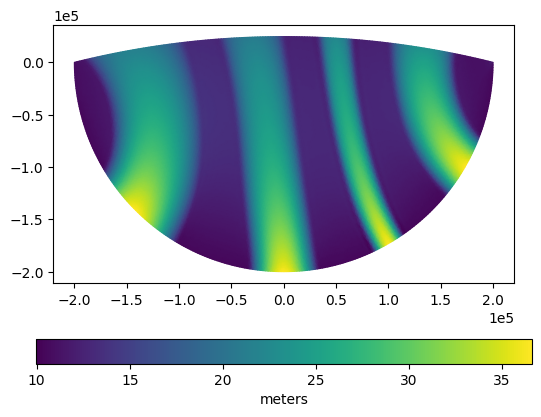

In [41]:
fig, axes = icepack.plot.subplots()
colors = firedrake.tripcolor(s, axes=axes)
fig.colorbar(colors, label="meters", orientation="horizontal");

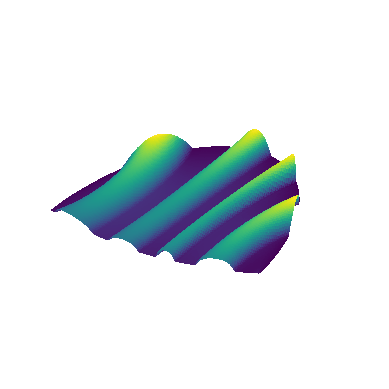

In [42]:
fig = plt.figure()
axes = fig.add_subplot(projection="3d")
axes.set_box_aspect((50.0, -50.0, 5.0))
axes.set_axis_off()
firedrake.trisurf(s, axes=axes);

# Demonstration
We have a topography that we've solved with our ice flow model Now we want to solve equations that describe surface water fluxes and water routing and use this parameterization to see where water flows on the mesh. We first define a new function space that we can use on our mesh.

In [43]:
z = firedrake.Function(Z)
z_n = firedrake.Function(Z)
δt = firedrake.Constant(30.0)
z_n.sub(0).assign(h_water_0)
z.sub(0).assign(h_water_0);

In [44]:
from firedrake import inner

k_0 = firedrake.Constant(0.5)
k = firedrake.interpolate(k_0,Q2)
#δk = Constant(4.0)
#k_expr = firedrake.conditional(s >=30, 1.0, 0.0)


In [45]:
from firedrake import div, grad, dx

g = firedrake.Constant(9.8)


h_water, q = firedrake.split(z)
h_n = firedrake.split(z_n)[0]
ϕ, v = firedrake.TestFunctions(Z)

F_h = ((h_water - h_n) / δt + div(q)) * ϕ * dx

ν = firedrake.FacetNormal(Q2.mesh())
#outflow = firedrake.max_value(inner(q, ν), 0)

friction = k * inner(q, q)**0.5 * q

gravity = -g * h_water**3 * grad(s+h_water)
#gravity_terminus = -g *h_water**3 * -(s + h_water) * ν

F_q = inner(friction - gravity, v) * dx
#F_t = inner(friction - gravity_terminus,v) * firedrake.ds(2)
F = F_h + F_q

In [46]:
ϵ = firedrake.Constant(1e-5)
friction = k * (inner(q, q) + ϵ**2)**0.5 * q
gravity = -g * h_water**3 * grad(s + h_water)
F_qϵ = inner(friction - gravity, v) * dx
#F_tϵ = inner(friction - gravity_terminus,v) * firedrake.ds(2)
F_ϵ = F_h + F_qϵ

# Boundary conditions
Here we define the zero flux condition on the inlet side of the mesh. This could be changed based on nodes or areas where we anticipate high rates of melt.

In [47]:
bcs = firedrake.DirichletBC(Z.sub(1), firedrake.zero(), "on_boundary")
J = firedrake.derivative(F_ϵ, z)
problem = firedrake.NonlinearVariationalProblem(F, z, bcs, J=J)

In [48]:
from firedrake.petsc import PETSc

upper = firedrake.Function(Z)
with upper.dat.vec as upper_vec:
    upper_vec.set(PETSc.INFINITY)


lower = firedrake.Function(Z)
with lower.sub(1).dat.vec as lower_vec:
    lower_vec.set(PETSc.NINFINITY)



In [49]:
params = {
    "solver_parameters": {
        "snes_type": "vinewtonrsls",
        "ksp_type": "gmres",
        "pc_type": "lu",
    }
}

solver = firedrake.NonlinearVariationalSolver(problem, **params)

In [50]:
import tqdm

final_time = 86400 * 7
num_steps = int(final_time / float(δt))

hs = [z.sub(0).copy(deepcopy=True)]
qs = [z.sub(1).copy(deepcopy=True)]

for step in tqdm.trange(num_steps):
    solver.solve(bounds=(lower, upper))
    z_n.assign(z)

    h, q = z.split()
    hs.append(h.copy(deepcopy=True))
    qs.append(q.copy(deepcopy=True))



  0%|                                                 | 0/20160 [00:00<?, ?it/s]/home/hoffmaao/firedrake/src/firedrake/firedrake/function.py:327: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)
 38%|█████████████▌                      | 7623/20160 [58:24<1:36:04,  2.18it/s]


KeyboardInterrupt: 

In [56]:
from firedrake import ds

ν = firedrake.FacetNormal(mesh)
flux_out=[]
for i in range(len(hs)):
    flux_out.append(np.array([firedrake.assemble(inner(qs[i], ν) * ds(2))]))

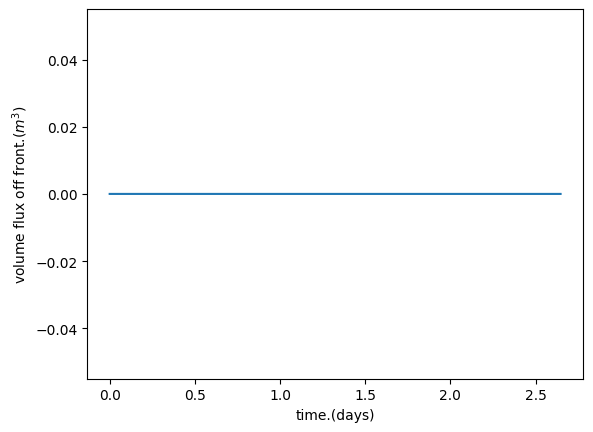

In [57]:
fig,ax=plt.subplots()
ts = np.linspace(0.0, final_time/86400, num_steps + 1)
ax.set_xlabel("time.(days)")
ax.set_ylabel(r"volume flux off front.($m^3$)")
ax.plot(ts[:len(flux_out)],np.array(flux_out).flatten())

In [58]:
qms = [firedrake.project(inner(q, q)**0.5, Q) for q in qs]
area = firedrake.assemble(firedrake.Constant(1) * dx(mesh))
qavgs = np.array([firedrake.assemble(q * dx) / area for q in qms])
print(f"Average flux: {qavgs.mean()*100**2:5.1f} m²/s")
print(f"Fudge flux:   {float(ϵ)*100**2:5.1f} m²/s")

Average flux:   7.9 m²/s
Fudge flux:     0.1 m²/s


In [59]:
volumes = np.array([firedrake.assemble(h * dx) for h in hs])
volume_error = (volumes.max() - volumes.min()) / volumes.mean()
print(f"Volume relative error: {volume_error:5.2g}")

Volume relative error: 0.084


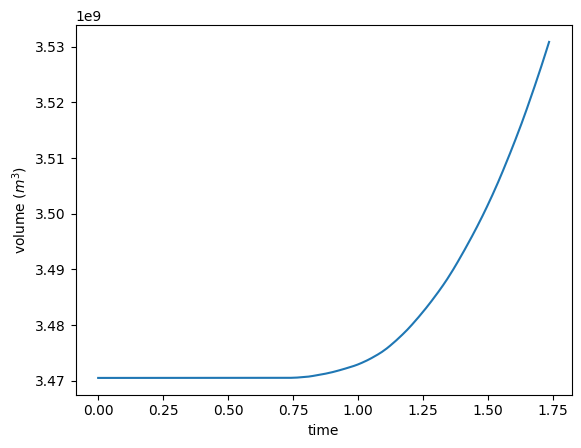

In [66]:
fig, axes = plt.subplots()
ts = np.linspace(0.0, final_time/86400, num_steps + 1)
axes.set_xlabel("time")
axes.set_ylabel("volume ($m^3$)")
axes.plot(ts[:5000], volumes[:5000]);

In [67]:
X_coord=firedrake.interpolate(x[0],Q)
Y_coord=firedrake.interpolate(x[1],Q)

In [70]:
%%capture

from matplotlib.animation import FuncAnimation
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots()
axes.set_aspect("equal")
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

firedrake.triplot(mesh, axes=axes)
CS=axes.tricontour(X_coord.dat.data, Y_coord.dat.data, s.dat.data, 15, linewidths=0.5, colors='black')
axes.clabel(CS, CS.levels, inline=True, fontsize=10)
#axes.tricontourf(x.data.data, y.dat.data, s.dat.data, 15)

colors = firedrake.tripcolor(
    hs[0], axes=axes,vmin=0.0, vmax=.5, cmap="Blues", num_sample_points=4)


fn_plotter = firedrake.FunctionPlotter(mesh, num_sample_points=4)
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(colors,cax=cax,label="sheet height.(m)")
fig.tight_layout()

def animate(h):
    colors.set_array(fn_plotter(h))

interval = 1e3 / 60
animation = FuncAnimation(fig, animate, frames=hs[::12], interval=interval)

animation.save(filename="shelf_flow_no_outflow.gif", writer="pillow")

